In [1]:
import tools.file as tf
import drawwithplt as Dplt
from drawwithplt import plt
Dplt.plt.style.use(["science", "grid"])

import numpy as np
import pandas as pd
import copy
import pickle as pkl
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
import time
import requests

In [12]:
# 读取CSV文件
df = pd.read_csv('Data/TrafficNet/地名地址信息;交通地名;路口名.csv')

# 显示前几行数据以检查
df[56:58]

c:\Users\LIFTES-NONET\Anaconda3\envs\py3.7\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,pcode,type,gridcode,typecode,citycode,adname,id,address,adcode,pname,...,name,location,longitude_gcj02,latitude_gcj02,longitude_wgs84,latitude_wgs84,typecode_single,大类,中类,小类
56,110000,地名地址信息;交通地名;路口名,5915347902,190302,10,房山区,B0FFHPLCIS,房山区,110111,北京市,...,七孤路与涞宝路交叉口,"115.623374,39.643195",115.623374,39.643195,115.617340,39.642192,190302,地名地址信息,交通地名,路口名
57,110000,地名地址信息;交通地名;路口名,5915356011,190302,10,房山区,B0FFHPGTJA,房山区,110111,北京市,...,六石路与涞宝路交叉口,"115.632419,39.638776",115.632419,39.638776,115.626375,39.637763,190302,地名地址信息,交通地名,路口名


In [13]:
def Filter_by_coordinates(df, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    筛选在指定经纬度范围内的数据。

    参数:
        df (pd.DataFrame): 输入的数据，应包含'longitude'和'latitude'两列。
        long_min (float, optional): 最小经度值。默认为None。
        long_max (float, optional): 最大经度值。默认为None。
        lat_min (float, optional): 最小纬度值。默认为None。
        lat_max (float, optional): 最大纬度值。默认为None。

    返回:
        pd.DataFrame: 筛选后的数据。
    """
    
    if long_min is not None:
        df = df[df['longitude_gcj02'] >= long_min]
    if long_max is not None:
        df = df[df['longitude_gcj02'] <= long_max]
    if lat_min is not None:
        df = df[df['latitude_gcj02'] >= lat_min]
    if lat_max is not None:
        df = df[df['latitude_gcj02'] <= lat_max]
    
    return df


In [14]:
def Plot_points_within_bounds(df, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    根据指定的经纬度范围，绘制图中的点。如果没有指定范围，就使用数据的最小和最大值。
    
    参数:
    - df: DataFrame，包含经纬度信息的数据
    - long_min, long_max: 经度的最小和最大值
    - lat_min, lat_max: 纬度的最小和最大值
    """
    # 如果没有指定范围，则使用数据的最小和最大值
    if long_min is None:
        long_min = df['longitude_gcj02'].min()
    if long_max is None:
        long_max = df['longitude_gcj02'].max()
    if lat_min is None:
        lat_min = df['latitude_gcj02'].min()
    if lat_max is None:
        lat_max = df['latitude_gcj02'].max()

    # 根据指定的经纬度范围过滤数据
    df_filtered = df[(df['longitude_gcj02'] >= long_min) & 
                     (df['longitude_gcj02'] <= long_max) & 
                     (df['latitude_gcj02'] >= lat_min) & 
                     (df['latitude_gcj02'] <= lat_max)]
    
    # 添加额外的空间，确保点不会紧贴图像边缘
    padding_long = (long_max - long_min) * 0.05
    padding_lat = (lat_max - lat_min) * 0.05
    
    # 绘制图形
    plt.figure(figsize=(5, 5))
    plt.scatter(df_filtered['longitude_gcj02'], df_filtered['latitude_gcj02'], s=5, color='blue')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.xlim(long_min - padding_long, long_max + padding_long)  # 设置x轴范围
    plt.ylim(lat_min - padding_lat, lat_max + padding_lat)   # 设置y轴范围


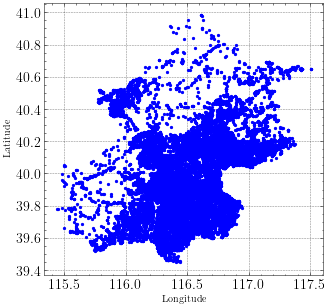

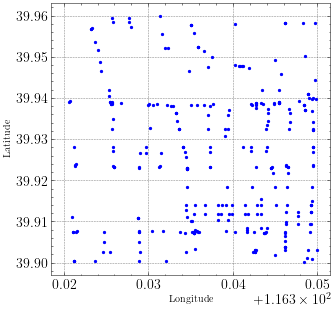

In [15]:
Plot_points_within_bounds(df)
Plot_points_within_bounds(df,116.32,116.35,39.90,39.96)

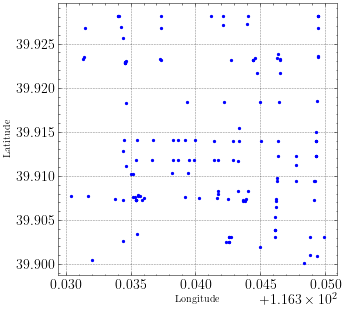

In [16]:
tmpdf = Filter_by_coordinates(df,116.33,116.35,39.90,39.93)
Plot_points_within_bounds(tmpdf)

In [17]:
def Haversine_distance(origin, destination):
    """
    使用Haversine公式计算两点间的距离。
    返回的距离单位为米。
    """
    # 地球半径，单位为米
    R = 6371000
    lat1, lon1 = math.radians(origin[1]), math.radians(origin[0])
    lat2, lon2 = math.radians(destination[1]), math.radians(destination[0])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

def Is_adjacent(origin, destination, threshold=1.1, sleeptime=2):
    """
    使用API导航来判断两个路口是否相邻。
    如果导航路径等于或略大于两点间的直线距离，则判断两者间有道路连接。
    """
    time.sleep(sleeptime)
    # 这里使用高德API作为示例
    api_url = "https://restapi.amap.com/v3/direction/walking?origin={},{}&destination={},{}&key=feac9a525ffa71a7f5d2a035bf2e0b1c"
    
    retries = 0
    max_retries = 10
    while retries < max_retries:
        try:
            response = requests.get(api_url.format(origin[0], origin[1], destination[0], destination[1]))
            data = response.json()

            # 计算导航距离
            nav_distance = data['route']['paths'][0]['distance']

            # 计算两点间的直线距离
            straight_distance = Haversine_distance(origin, destination)

            print(nav_distance, straight_distance)
            return float(nav_distance) <= straight_distance * threshold

        except requests.RequestException as e:  # 包括超时、连接错误等
            if retries < max_retries - 1:  # 判断是否达到重试次数
                print(f"Error occurred: {e}. Retrying in 5 seconds...")
                time.sleep(5)
                retries += 1
            else:
                print(f"Max retries reached. Exiting...")
                return False

    return False

def Get_direction(origin, destination):
    """
    通过经纬度计算两点间连线的tan值，来判断道路是东西连接还是南北连接。
    """
    delta_x = destination[0] - origin[0]
    delta_y = destination[1] - origin[1]
    
    # 计算tan值
    tan_value = abs(delta_y / delta_x)
    
    # 判断方向
    if tan_value > 1:
        return "南北方向"
    else:
        return "东西方向"

def Merge_close_points(df, threshold=30):
    """
    归并距离小于给定阈值的点。
    返回一个新的DataFrame，其中距离小于阈值的点已被归并。
    """
    used_indices = set()
    new_rows = []
    
    for i, row in df.iterrows():
        if i in used_indices:
            continue

        close_points = []
        for j, compare_row in df.iterrows():
            if j in used_indices:
                continue
            distance = Haversine_distance((row['longitude_gcj02'], row['latitude_gcj02']), 
                                          (compare_row['longitude_gcj02'], compare_row['latitude_gcj02']))
            if distance <= threshold:
                close_points.append((compare_row['longitude_gcj02'], compare_row['latitude_gcj02']))
                used_indices.add(j)
                
        # 计算归并点的均值坐标
        avg_longitude = sum(p[0] for p in close_points) / len(close_points)
        avg_latitude = sum(p[1] for p in close_points) / len(close_points)
        
        # 找到与均值最接近的点，并使用该点的所有列信息
        closest_point = min(close_points, key=lambda p: Haversine_distance(p, (avg_longitude, avg_latitude)))
        closest_row = df[(df['longitude_gcj02'] == closest_point[0]) & 
                         (df['latitude_gcj02'] == closest_point[1])].iloc[0]
        
        new_row = closest_row.to_dict()
        new_row['longitude_gcj02'] = avg_longitude
        new_row['latitude_gcj02'] = avg_latitude
        new_rows.append(new_row)

    return pd.DataFrame(new_rows)


# 使用示例
# origin = (116.397570, 39.908821)
# destination = (116.398570, 39.908821)
# if Is_adjacent(origin, destination):
#     print("两点相邻")
#     print("方向:", Get_direction(origin, destination))


In [18]:
def Assign_ids_to_intersections(df):
    """
    对每个路口分配一个ID。
    """
    df = df.reset_index(drop=True)
    df['id'] = df.index
    return df

def AngleBetween(p1, p2):
    """
    计算点p1和p2之间的角度。
    """
    deltaY = p2[1] - p1[1]
    deltaX = p2[0] - p1[0]
    angle = math.atan2(deltaY, deltaX)
    return math.degrees(angle)

def FindNeighbors(df, n_neighbors=9):  # 我们现在需要查找至少9个邻居（包括点自己）
    coords = df[['latitude_gcj02', 'longitude_gcj02']].values
    ids = df['id'].values
    
    directions = {
        'north': (-90, -45),
        'east': (-45, 45),
        'south': (45, 135),
        'west': (135, 180),
    }
    
    for i, coord in enumerate(coords):
        distances, indices = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(coords).kneighbors([coord])
        
        for direction, (angle_min, angle_max) in directions.items():
            nearest_found = False
            for idx in indices[0][1:]:  # 跳过点自己
                target_coord = coords[idx]
                angle = AngleBetween(coord, target_coord)
                
                if angle_min <= angle < angle_max:
                    if not nearest_found:
                        df.at[i, f'nearest_{direction}'] = ids[idx]
                        nearest_found = True
                    else:
                        df.at[i, f'second_nearest_{direction}'] = ids[idx]
                        break
    
    return df

def GenerateAdjacentDict(df, sleeptime = 5):
    adjacent_dict = {}
    
    for index, row in df.iterrows():
        for direction in ["east", "west", "north", "south"]:
            origin_id = row["id"]
            
            # 检查df中是否存在最近邻点或第二近邻点
            if pd.notnull(row[f"nearest_{direction}"]):
                nearest_id = int(row[f"nearest_{direction}"])
            else:
                continue
                
            if pd.notnull(row[f"second_nearest_{direction}"]):
                second_nearest_id = int(row[f"second_nearest_{direction}"])
            else:
                second_nearest_id = None

            origin_coord = (df[df["id"] == origin_id]["longitude_gcj02"].values[0], 
                            df[df["id"] == origin_id]["latitude_gcj02"].values[0])
            
            # 获取最近邻点的坐标
            nearest_coord = (df[df["id"] == nearest_id]["longitude_gcj02"].values[0], 
                             df[df["id"] == nearest_id]["latitude_gcj02"].values[0])
            
            # 检查最近邻点是否有连接
            if Is_adjacent(origin_coord, nearest_coord, threshold=1.1, sleeptime = sleeptime):
                adjacent_dict[(origin_id, nearest_id)] = direction
            elif second_nearest_id:  # 如果最近邻点没有连接，检查第二近邻点
                second_nearest_coord = (df[df["id"] == second_nearest_id]["longitude_gcj02"].values[0], 
                                        df[df["id"] == second_nearest_id]["latitude_gcj02"].values[0])
                if Is_adjacent(origin_coord, second_nearest_coord, threshold=1.1, sleeptime = sleeptime):
                    adjacent_dict[(origin_id, second_nearest_id)] = direction

    return adjacent_dict



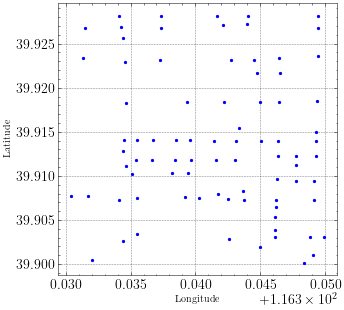

In [21]:
tmpdf = Merge_close_points(tmpdf, threshold=80)
Plot_points_within_bounds(tmpdf)

In [22]:
tmpdf = Assign_ids_to_intersections(tmpdf)
tmpdf = FindNeighbors(tmpdf)
adj_dict = GenerateAdjacentDict(tmpdf)

1011 772.2985349631189
1366 801.5762380390747
425 314.32374670749607
546 432.1671941334097
145 110.25031528016822
399 328.9991160987213
351 351.9117053059012
253 235.31910934480086
382 344.04656361360657
465 405.35700767562906
684 452.40145020373546
778 555.5749614011006
840 604.3908111208073
718 579.6122479227541
229 205.1314552261021
347 323.2966356210553
587 512.1572404276828
681 538.2969743802979
122 119.27257240177872
995 665.9686027737272
959 655.3846722653964
118 117.30889786495322
449 334.18186575306106
553 431.4056445873424
465 451.4272989106362
229 205.1314552261021
348 319.9040190154945
146 124.000980153534
559 453.7761298479201
465 451.4272989106362
834 649.6992048037971
987 616.0220441283892
331 306.54477335984774
347 323.2966356210553
336 314.24153068619563
191 186.34319270557356
112 113.53787450474444
306 104.21735905334465
411 191.73120854468954
124 137.27307917665962
192 186.34319270557356
160 137.38197440742007
265 219.90547651987993
112 113.53787450474444
331 306.544

In [23]:
tf.Save_data(adj_dict, "Data/TrafficNet/adj_dict.pkl")

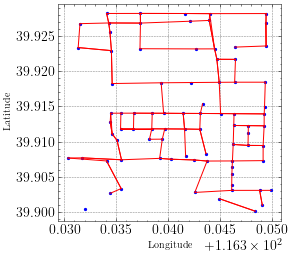

In [24]:
def Plot_points_and_lines_within_bounds(df, adj_dict, long_min=None, long_max=None, lat_min=None, lat_max=None):
    """
    根据指定的经纬度范围，绘制图中的点和连接的线。如果没有指定范围，就使用数据的最小和最大值。
    
    参数:
    - df: DataFrame，包含经纬度信息的数据
    - adj_dict: 字典，包含相邻路口的id和方向信息
    - long_min, long_max: 经度的最小和最大值
    - lat_min, lat_max: 纬度的最小和最大值
    """
    # 如果没有指定范围，则使用数据的最小和最大值
    if long_min is None:
        long_min = df['longitude_gcj02'].min()
    if long_max is None:
        long_max = df['longitude_gcj02'].max()
    if lat_min is None:
        lat_min = df['latitude_gcj02'].min()
    if lat_max is None:
        lat_max = df['latitude_gcj02'].max()

    # 根据指定的经纬度范围过滤数据
    df_filtered = df[(df['longitude_gcj02'] >= long_min) & 
                     (df['longitude_gcj02'] <= long_max) & 
                     (df['latitude_gcj02'] >= lat_min) & 
                     (df['latitude_gcj02'] <= lat_max)]
    
    # 添加额外的空间，确保点不会紧贴图像边缘
    padding_long = (long_max - long_min) * 0.05
    padding_lat = (lat_max - lat_min) * 0.05
    
    # 绘制图形
    plt.figure(figsize=(4, 4))
    plt.scatter(df_filtered['longitude_gcj02'], df_filtered['latitude_gcj02'], s=5, color='blue')
    
    # 绘制两点之间的连线
    for (origin_id, destination_id), direction in adj_dict.items():
        # 获取起点和终点的坐标
        origin_coords = df[df["id"] == origin_id][['longitude_gcj02', 'latitude_gcj02']].values[0]
        dest_coords = df[df["id"] == destination_id][['longitude_gcj02', 'latitude_gcj02']].values[0]
        
        # 画线
        plt.plot([origin_coords[0], dest_coords[0]], [origin_coords[1], dest_coords[1]], color='red')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.xlim(long_min - padding_long, long_max + padding_long)  # 设置x轴范围
    plt.ylim(lat_min - padding_lat, lat_max + padding_lat)   # 设置y轴范围
    plt.show()

Plot_points_and_lines_within_bounds(tmpdf, adj_dict)

# 测试新路网拓扑

   A      B  DISTANCE  LINKTYPE NAME  TIME_SPD  CAPACITY  LANES  SPEED  SCRNO  \
0  1  25131   0.13791        22   CC         5     99999      9      5      0   
1  1  25271   0.12515        22   CC         5     99999      9      5      0   
2  1  25375   0.13165        22   CC         5     99999      9      5      0   
3  1  25541   0.21009        22   CC         5     99999      9      5      0   
4  2  25327   0.03714        22   CC         5     99999      9      5      0   

   BUSLANE  ONEWAY BUSPERIOD  LINKID2014  CNTID  CAPPERLANE  FLAG  \
0        0       0      None           0      0     11111.0     0   
1        0       0      None           0      0     11111.0     0   
2        0       0      None           0      0     11111.0     0   
3        0       0      None           0      0     11111.0     0   
4        0       0      None           0      0     11111.0     0   

                                            geometry  
0  LINESTRING (502758.992 304037.173, 50263

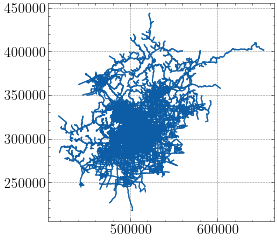

In [18]:
import geopandas as gpd

# 读取Shapefile文件
gdf = gpd.read_file('./Data/Network/Network_Final_Y2022.shp')

# 打印GeoDataFrame的前几行来检查数据
print(gdf.head())

gdf.plot()
Dplt.SaveFig(1,"TotalNet.png","./Figure/RoadNet/")

In [3]:
print(gdf['LINKTYPE'].unique())

[22 20 19  2 18  1 12  4  3  6  9  7  5 11]


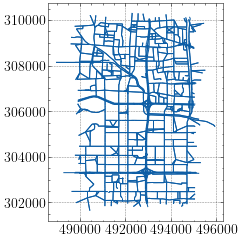

In [3]:
import geopandas as gpd
from shapely.geometry import box

# 读取Shapefile文件
gdf = gpd.read_file('./Data/Network/Network_Final_Y2022.shp')

# 定义一个矩形区域的边界框（这里需要您提供x_min, y_min, x_max, y_max）
# 例如，这些坐标可能代表经度和纬度
x_min, y_min, x_max, y_max = [490000, 302000, 495000, 310000]
bbox = box(x_min, y_min, x_max, y_max)

# 使用上述边界框来筛选GeoDataFrame中的数据
# 只选择与边界框相交的道路
roads_within_bbox = gdf[gdf.intersects(bbox)]

# 现在绘制这个区域内的路网
roads_within_bbox.plot()

# 显示图形
import matplotlib.pyplot as plt
plt.show()


c:\Users\LIFTES-NONET\Anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.


Number of intersections extracted: 456


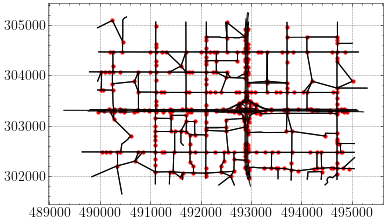

In [52]:
import geopandas as gpd
from shapely.geometry import box, MultiPoint
import matplotlib.pyplot as plt

# 读取Shapefile文件
gdf = gpd.read_file('./Data/Network/Network_Final_Y2022.shp')

# 定义区域边界框
x_min, y_min, x_max, y_max = [490000, 302000, 495000, 305000]
bbox = box(x_min, y_min, x_max, y_max)

# 筛选出与边界框相交的路网数据
roads_within_bbox = gdf[gdf.intersects(bbox)]

# 创建一个空的GeoDataFrame来存储路口
intersections = gpd.GeoDataFrame(columns=['geometry'], crs=gdf.crs)

# 找出所有道路的相交点
for road1 in roads_within_bbox.geometry:
    for road2 in roads_within_bbox.geometry:
        if road1 == road2:  # 避免自己与自己相交
            continue
        intersection = road1.intersection(road2)
        if intersection.is_empty:  # 如果没有交点则跳过
            continue
        if "Point" == intersection.type:
            intersections = intersections.append({'geometry': intersection}, ignore_index=True)
        elif intersection.geom_type == "MultiPoint":
            for point in intersection.geoms:
                intersections = intersections.append({'geometry': point}, ignore_index=True)

        # 如果是线段相交，我们通常不将其视为一个路口，因此这里不考虑线与线相交


# 移除重复的路口位置
intersections = intersections.drop_duplicates(subset=['geometry'])
print(f"Number of intersections extracted: {len(intersections)}")

# 绘制边界框内的路网
roads_within_bbox.plot(ax=plt.gca(), color='black')

# 绘制路口
intersections.plot(ax=plt.gca(), color='red', markersize=10)

# 显示图形
# plt.show()
Dplt.SaveFig(1,"CrossRoad.png","./Figure/RoadNet/")

In [ ]:
import geopandas as gpd
from shapely.geometry import box

def extract_intersections_and_roads(shapefile_path, x_min, y_min, x_max, y_max):
    """
    Extracts intersections and roads within a bounding box from a given shapefile.

    Parameters:
    shapefile_path (str): The file path to the shapefile.
    x_min (float): The minimum x coordinate of the bounding box.
    y_min (float): The minimum y coordinate of the bounding box.
    x_max (float): The maximum x coordinate of the bounding box.
    y_max (float): The maximum y coordinate of the bounding box.

    Returns:
    intersections (GeoDataFrame): The intersections within the bounding box.
    roads_within_bbox (GeoDataFrame): The roads within the bounding box.
    """

    # 读取Shapefile文件
    gdf = gpd.read_file(shapefile_path)

    # 定义区域边界框
    bbox = box(x_min, y_min, x_max, y_max)

    # 筛选出与边界框相交的路网数据
    roads_within_bbox = gdf[gdf.intersects(bbox)]

    # 创建一个空的GeoDataFrame来存储路口
    intersections = gpd.GeoDataFrame(columns=['geometry'], crs=gdf.crs)

    # 找出所有道路的相交点
    for road1 in roads_within_bbox.geometry:
        for road2 in roads_within_bbox.geometry:
            if road1.equals(road2):  # 避免自己与自己相交
                continue
            intersection = road1.intersection(road2)
            if intersection.is_empty:  # 如果没有交点则跳过
                continue
            if "Point" == intersection.geom_type:
                intersections = intersections.append({'geometry': intersection}, ignore_index=True)
            elif "MultiPoint" == intersection.geom_type:
                for point in intersection.geoms:
                    intersections = intersections.append({'geometry': point}, ignore_index=True)
            # 不考虑线与线相交作为路口

    # 移除重复的路口位置
    intersections = intersections.drop_duplicates(subset=['geometry'])

    return intersections, roads_within_bbox

# 使用示例
shapefile_path = './Data/Network/Network_Final_Y2022.shp'
x_min, y_min, x_max, y_max = [490000, 302000, 495000, 305000]
intersections, roads_within_bbox = extract_intersections_and_roads(shapefile_path, x_min, y_min, x_max, y_max)


In [59]:
from scipy.sparse import lil_matrix, csr_matrix

def simplify_network(adjacency_matrix, intersection_dict):
    if not isinstance(adjacency_matrix, lil_matrix):
        adjacency_matrix = adjacency_matrix.tolil()

    nodes_to_remove = set()
    for i in range(adjacency_matrix.shape[0]):
        # Get the indices of the non-zero elements in the row and column
        non_zero_in_row = adjacency_matrix[i].nonzero()[1]
        non_zero_in_col = adjacency_matrix[:, i].nonzero()[0]
        
        # Create a set of unique indices excluding the self-loop
        unique_indices = set(non_zero_in_row).union(set(non_zero_in_col)) - {i}

        if len(unique_indices) == 2:  # Node i has only two neighbors
            # Mark the node for removal
            nodes_to_remove.add(i)

            # Connect the two neighbors directly
            j, k = unique_indices
            adjacency_matrix[j, k] = 1
            adjacency_matrix[k, j] = 1

    # Remove the nodes from the adjacency matrix
    adjacency_matrix = adjacency_matrix.tolil()
    for node in nodes_to_remove:
        adjacency_matrix[node, :] = 0  # Remove all connections from node
        adjacency_matrix[:, node] = 0  # Remove all connections to node

    # Remove the nodes from the intersection dictionary
    for node in sorted(nodes_to_remove, reverse=True):
        del intersection_dict[node]

    # Create a new mapping for the remaining nodes
    remaining_nodes = list(set(range(adjacency_matrix.shape[0])) - nodes_to_remove)
    simplified_intersection_dict = {new_idx: intersection_dict[old_idx] for new_idx, old_idx in enumerate(remaining_nodes)}

    # Construct the new adjacency matrix with remaining nodes
    new_adjacency_matrix = adjacency_matrix[remaining_nodes, :][:, remaining_nodes]

    return simplified_intersection_dict, new_adjacency_matrix.tocsr()

# 使用示例
# simplified_intersection_dict, simplified_adjacency_matrix = simplify_network(adjacency_matrix, intersection_dict)

def visualize_simplified_network(intersection_dict, adjacency_matrix):
    # This function will plot the network using the intersection_dict and adjacency_matrix
    fig, ax = plt.subplots()

    # Plot the edges using adjacency_matrix
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i, j] != 0:
                point1 = intersection_dict[i]
                point2 = intersection_dict[j]
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', lw=0.5)

    # Plot the intersections using intersection_dict
    for idx, point in intersection_dict.items():
        ax.plot(point[0], point[1], 'o', markersize=5, color='blue')

    plt.show()



In [73]:
def direction_to_index(direction):
    mapping = {'east': 0, 'north': 1, 'west': 2, 'south': 3}
    return mapping.get(direction, -1)  # 如果方向是unknown，返回-1

def determine_direction(lat1, lon1, lat2, lon2):
    # 计算两点之间的角度（以北方为0度，顺时针）
    angle = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1)) % 360
    if (angle <= 45) or (angle > 315):
        return 'north'
    elif 45 < angle <= 135:
        return 'east'
    elif 135 < angle <= 225:
        return 'south'
    else:  # 225 < angle <= 315
        return 'west'

def update_road_attributes(road_attributes, road_attributes_last, connected_nodes, road_toward):
    # 遍历所有的路口
    for node_id, neighbors in connected_nodes.items():
        for neighbor in neighbors:
            # 获取两个节点之间的方向
            direction_info = road_toward.get((node_id, neighbor))
            
            # 如果没有方向信息或者方向是unknown，则跳过
            if not direction_info or direction_info['direction'] == 'unknown':
                continue

            # 根据方向获取对应的列索引
            col_index = direction_to_index(direction_info['direction'])

            # 生成随机的a和b的值，确保它们的和小于等于1
            a_value = np.random.uniform(0, 1)
            b_value = np.random.uniform(0, 1 - a_value)
            
            # 生成随机的q的值，范围在1到100之间
            q_value = np.random.randint(1, 101)
            
            # 更新road_attributes的值
            road_attributes['a'][node_id, col_index] = a_value
            road_attributes['b'][node_id, col_index] = b_value
            road_attributes['q'][node_id, col_index] = q_value
            
            # 更新road_attributes_last的值，这里我们假设它们与road_attributes相同
            # 如果需要不同的逻辑，您可以在这里进行调整
            road_attributes_last['a'][node_id, col_index] = a_value
            road_attributes_last['b'][node_id, col_index] = b_value
            road_attributes_last['q'][node_id, col_index] = q_value

    return road_attributes, road_attributes_last



In [74]:
import geopandas as gpd
import numpy as np
from scipy.sparse import lil_matrix
import numpy as np
import copy
from scipy.sparse import csr_matrix

# Helper function to find the index of the closest intersection to a given point
def find_closest_index(point, intersection_dict, threshold=300):
    closest_idx = None
    min_dist = float('inf')
    for idx, p in intersection_dict.items():
        dist = np.linalg.norm(np.array(point) - np.array(p))
        if dist < min_dist:
            closest_idx = idx
            min_dist = dist
    if min_dist > threshold:
        print(f"No close intersection found for point {point}, closest distance: {min_dist}")
        return None
    # print(f"Closest intersection for point {point} is {closest_idx} at distance {min_dist}")
    return closest_idx


def create_road_network(intersections_gdf, roads_gdf):
    # Create a dictionary of intersection positions
    intersection_dict = {}
    for idx, intersection in enumerate(intersections_gdf.geometry):
        coords = intersection.coords[:]  # 获取坐标数组
        if len(coords) >= 1:
            # 将坐标数组的第一个坐标作为路口位置
            intersection_dict[idx] = coords[0]
    
    # Initialize the adjacency matrix
    num_intersections = len(intersection_dict)
    adjacency_matrix = lil_matrix((num_intersections, num_intersections), dtype=int)

    for road in roads_gdf.itertuples():
        start_point = road.geometry.coords[0]
        end_point = road.geometry.coords[-1]
        start_idx = find_closest_index(start_point, intersection_dict)
        end_idx = find_closest_index(end_point, intersection_dict)
        if start_idx is not None and end_idx is not None:
            adjacency_matrix[start_idx, end_idx] = 1
            adjacency_matrix[end_idx, start_idx] = 1
        else:
            print(f"Failed to find intersections for road between {start_point} and {end_point}")


    # Converting the adjacency matrix to CSR format for more efficient matrix operations
    adjacency_matrix = adjacency_matrix.tocsr()
    
    return intersection_dict, adjacency_matrix


def extract_parameters(adjacency_matrix, location_dict):
    num_nodes = adjacency_matrix.shape[0]
    
    # 确保 adjacency_matrix 是稀疏矩阵形式
    if not isinstance(adjacency_matrix, csr_matrix):
        adjacency_matrix = csr_matrix(adjacency_matrix)
    
    # 初始化 X 和 X_last
    X = np.zeros((num_nodes, 4))
    X_last = np.zeros((num_nodes, 4))
    
    # 初始化 road_attributes 和 road_attributes_last
    road_attributes = {'a': np.zeros((num_nodes, 4)), 'b': np.zeros((num_nodes, 4)), 'q': np.zeros((num_nodes, 4))}
    road_attributes_last = {'a': np.zeros((num_nodes, 4)), 'b': np.zeros((num_nodes, 4)), 'q': np.zeros((num_nodes, 4))}

    
    # 初始化 connected_nodes 和 road_toward 字典
    connected_nodes = {}
    road_toward = {}

    # 构建 connected_nodes 字典
    for i in range(num_nodes):
        # 对于每个节点，找到所有相邻的节点（即邻接矩阵中的非零元素索引）
        neighbors = adjacency_matrix[i].nonzero()[1]
        connected_nodes[i] = neighbors.tolist()
    
    # 构建 road_toward 字典
    for i in range(num_nodes):
        for j in connected_nodes[i]:
            if (i, j) not in road_toward:
                direction = 'unknown'
                if i in location_dict and j in location_dict:
                    lat1, lon1 = location_dict[i]
                    lat2, lon2 = location_dict[j]
                    # 计算方向
                    direction = determine_direction(lat1, lon1, lat2, lon2)
                
                road_toward[(i, j)] = {'direction': direction}
                # 如果道路是双向的，也为相反方向添加条目
                if adjacency_matrix[j, i] > 0 and (j, i) not in road_toward:
                    # 需要根据(j, i)重新计算方向
                    opposite_direction = determine_direction(lat2, lon2, lat1, lon1)
                    road_toward[(j, i)] = {'direction': opposite_direction}
    
    road_attributes, road_attributes_last = update_road_attributes(road_attributes, road_attributes_last, connected_nodes, road_toward)

    return X, X_last, road_attributes, road_attributes_last, connected_nodes, road_toward


Number of roads within bbox: 902
Sample road geometries: 1130    LINESTRING (492522.937 305046.050, 492521.625 ...
1131    LINESTRING (492522.937 305046.050, 492886.000 ...
1137    LINESTRING (491614.244 304184.132, 491322.832 ...
1138    LINESTRING (491614.244 304184.132, 491711.024 ...
1139    LINESTRING (491614.244 304184.132, 491711.938 ...
Name: geometry, dtype: geometry
No close intersection found for point (489836.0878875526, 301984.2024015736), closest distance: 540.6062100734734
Failed to find intersections for road between (489836.0878875526, 301984.2024015736) and (490339.8770638752, 302201.24795902625)
No close intersection found for point (489950.15625, 304935.1875), closest distance: 339.0993130275523
Failed to find intersections for road between (490253.3574227325, 305087.0341099371) and (489950.15625, 304935.1875)
No close intersection found for point (489644.23996, 302480.61282), closest distance: 407.2768060832241
Failed to find intersections for road between (489644.

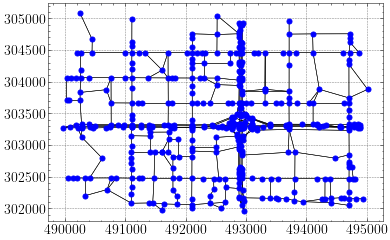

X: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
X_last: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
road_attributes: {'a': array([[0.        , 0.95884537, 0.37701158, 0.        ],
       [0.14681033, 0.22870072, 0.32635846, 0.02313794],
       [0.02936544, 0.        , 0.03237865, 0.75567015],
       ...,
       [0.62149409, 0.        , 0.28484282, 0.        ],
       [0.82620308, 0.        , 0.7760573 , 0.        ],
       [0.44774462, 0.        , 0.40361482, 0.        ]]), 'b': array([[0.        , 0.0328657 , 0.04770984, 0.        ],
       [0.32650875, 0.20915222, 0.35580489, 0.02664163],
       [0.69714665, 0.        , 0.45956111, 0.12912351],
       ...,
       [0.10006959, 0.        , 0.28704045, 0.        ],
       [0.13997758, 0.        , 0.18365436, 0.        ],
       [0.03830657, 0.        , 0.30062529, 0.        ]]), 'q': array([[ 0., 52., 93.,  0.],
       [ 4., 12.,  8., 

In [75]:
print(f"Number of roads within bbox: {len(roads_within_bbox)}")
print(f"Sample road geometries: {roads_within_bbox.geometry.head()}")

intersection_dict, adjacency_matrix = create_road_network(intersections, roads_within_bbox)

# Correct usage of the function
visualize_simplified_network(intersection_dict, adjacency_matrix)

X, X_last, road_attributes, road_attributes_last, connected_nodes, road_toward = extract_parameters(adjacency_matrix, intersection_dict)

print("X:", X)
print("X_last:", X_last)
print("road_attributes:", road_attributes)
print("connected_nodes:", connected_nodes)
print("road_toward:", road_toward)

In [76]:
# import geopandas as gpd
# import numpy as np
# from scipy.sparse import lil_matrix

# # Helper function to find the index of the closest intersection to a given point
# def find_closest_index(point, intersection_dict, threshold=0.0001):
#     for idx, p in intersection_dict.items():
#         # np.allclose will compare the points with the given absolute tolerance
#         if np.allclose(p[0], point, atol=threshold):
#             return idx
#     return None

# # Assuming you already have the intersections GeoDataFrame
# # intersections = ...

# # Assigning a unique number to each intersection and creating a dictionary of positions
# intersection_dict = {}
# for idx, intersection in enumerate(intersections.geometry):
#     intersection_dict[idx] = intersection.coords[:]

# # Initializing the adjacency matrix
# num_intersections = len(intersection_dict)
# adjacency_matrix = lil_matrix((num_intersections, num_intersections), dtype=int)

# # Assuming you have a GeoDataFrame of the road network with information about the roads
# # This GeoDataFrame is called roads_within_bbox

# # Filling the adjacency matrix
# for road in roads_within_bbox.itertuples():
#     start_point = road.geometry.coords[0]
#     end_point = road.geometry.coords[-1]
    
#     # Find the intersection number for the starting and ending points of the road
#     start_idx = find_closest_index(start_point, intersection_dict)
#     end_idx = find_closest_index(end_point, intersection_dict)
    
#     # If both the start and end points correspond to an intersection number
#     if start_idx is not None and end_idx is not None:
#         # Set the edge in the adjacency matrix
#         adjacency_matrix[start_idx, end_idx] = 1
#         adjacency_matrix[end_idx, start_idx] = 1  # If it's a two-way road, also set the connection in the opposite direction

# # Converting the adjacency matrix to CSR format for more efficient matrix operations
# adjacency_matrix = adjacency_matrix.tocsr()


# # 这样就创建了一个按图的数据结构存储的道路网络
# # 其中 `intersection_dict` 是路口编号和位置的字典
# # `adjacency_matrix` 是邻接矩阵，表示路口之间的直接连接状态

# visualize_simplified_network(intersection_dict, adjacency_matrix)
# Dplt.SaveFig(1,"area.png","./Figure/RoadNet/")


In [77]:
# simplified_intersection_dict, simplified_adjacency_matrix = simplify_network(adjacency_matrix, intersection_dict)
# # print(simplified_intersection_dict, simplified_adjacency_matrix)
# visualize_simplified_network(simplified_intersection_dict, simplified_adjacency_matrix)
# Dplt.SaveFig(1,"area-Simple.png","./Figure/RoadNet/")

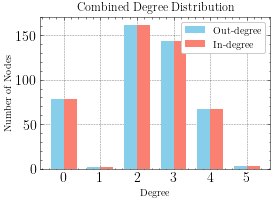

In [78]:
def plot_combined_degree_distribution(adjacency_matrix):
    # 计算每个节点的出度和入度
    out_degrees = adjacency_matrix.sum(axis=0).A1  # 出度
    in_degrees = adjacency_matrix.sum(axis=1).A1  # 入度

    # 设定直方图的bins
    degree_range = max(max(out_degrees), max(in_degrees)) + 1
    bins = np.arange(degree_range)

    # 创建度数的分布直方图
    plt.figure(figsize=(4, 3))

    # 计算每个度的频率
    out_degree_count = np.bincount(out_degrees, minlength=degree_range)
    in_degree_count = np.bincount(in_degrees, minlength=degree_range)

    # 为直方图设置宽度和位置偏移
    bar_width = 0.35
    indices = np.arange(degree_range)

    # 绘制出度分布直方图
    plt.bar(indices - bar_width / 2, out_degree_count, bar_width, color='skyblue', label='Out-degree')

    # 绘制入度分布直方图
    plt.bar(indices + bar_width / 2, in_degree_count, bar_width, color='salmon', label='In-degree')

    # 添加图例
    plt.legend()

    # 添加标题和轴标签
    plt.title('Combined Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.xticks(indices, indices)  # 设置x轴的刻度标签

    # 显示图表
    plt.tight_layout()

# 使用示例
plot_combined_degree_distribution(adjacency_matrix)
Dplt.SaveFig(1,"RoadNetDegree.png","./Figure/RoadNet/")


In [79]:


# 使用示例
# adjacency_matrix = np.array([[0, 1, 1],
#                              [1, 0, 0],
#                              [1, 0, 0]])
# intersection_dict = {0: (40.7128, -74.0060), 1: (34.0522, -118.2437), 2: (41.8781, -87.6298)}


